In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/processed/dataset.csv")
df.head()

,date_since,month,day,hour,dow,weekend,season,icon,usage_lag_1h,usage_lag_24h,usage
0,0,5,1,0,fri,0,summer,rain,0.0,0.0,9.0
1,0,5,1,1,fri,0,summer,rain,9.0,0.0,0.0
2,0,5,1,2,fri,0,summer,rain,0.0,0.0,4.0
3,0,5,1,3,fri,0,summer,rain,4.0,0.0,1.0
4,0,5,1,4,fri,0,summer,rain,1.0,0.0,4.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38016 entries, 0 to 38015
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_since     38016 non-null  int64  
 1   month          38016 non-null  int64  
 2   day            38016 non-null  int64  
 3   hour           38016 non-null  int64  
 4   dow            38016 non-null  object 
 5   weekend        38016 non-null  int64  
 6   season         38016 non-null  object 
 7   icon           38016 non-null  object 
 8   usage_lag_1h   38016 non-null  float64
 9   usage_lag_24h  38016 non-null  float64
 10  usage          38016 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 3.2+ MB


In [4]:
df.describe()

,date_since,month,day,hour,weekend,usage_lag_1h,usage_lag_24h,usage
count,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000
mean,791.500000,6.521465,15.741162,11.500000,0.285985,366.368003,365.979877,366.375289
std,457.267336,3.326862,8.806316,6.922278,0.451888,348.647777,348.518849,348.643015
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,395.750000,4.000000,8.000000,5.750000,0.000000,70.000000,69.000000,70.000000
50%,791.500000,7.000000,16.000000,11.500000,0.000000,276.000000,276.000000,276.000000
75%,1187.250000,9.000000,23.000000,17.250000,1.000000,559.000000,559.000000,559.000000
max,1583.000000,12.000000,31.000000,23.000000,1.000000,2016.000000,2016.000000,2016.000000


In [5]:
y = df["usage"]
X = df.drop(columns="usage")

In [6]:
from sklearn.model_selection import train_test_split

# --- STEP 1: SPLIT DATA INTO (TRAIN + VALID) AND (TEST) ---
# We reserve 20% of the total dataset for the final testing phase.
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# --- STEP 2: SPLIT (TRAIN + VALID) INTO (TRAIN) AND (VALID) ---
# By taking 25% of the remaining 80%, we allocate exactly 20% of the 
# original total data to the Validation set.
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=0.25, random_state=42, shuffle=True
)

# Final verification of dataset sizes
print(f"Train size: {len(X_train)} | Valid size: {len(X_valid)} | Test size: {len(X_test)}")

Train size: 22809 | Valid size: 7603 | Test size: 7604


Processing model: Ridge...
Processing model: RandomForest...
Processing model: XGBoost...


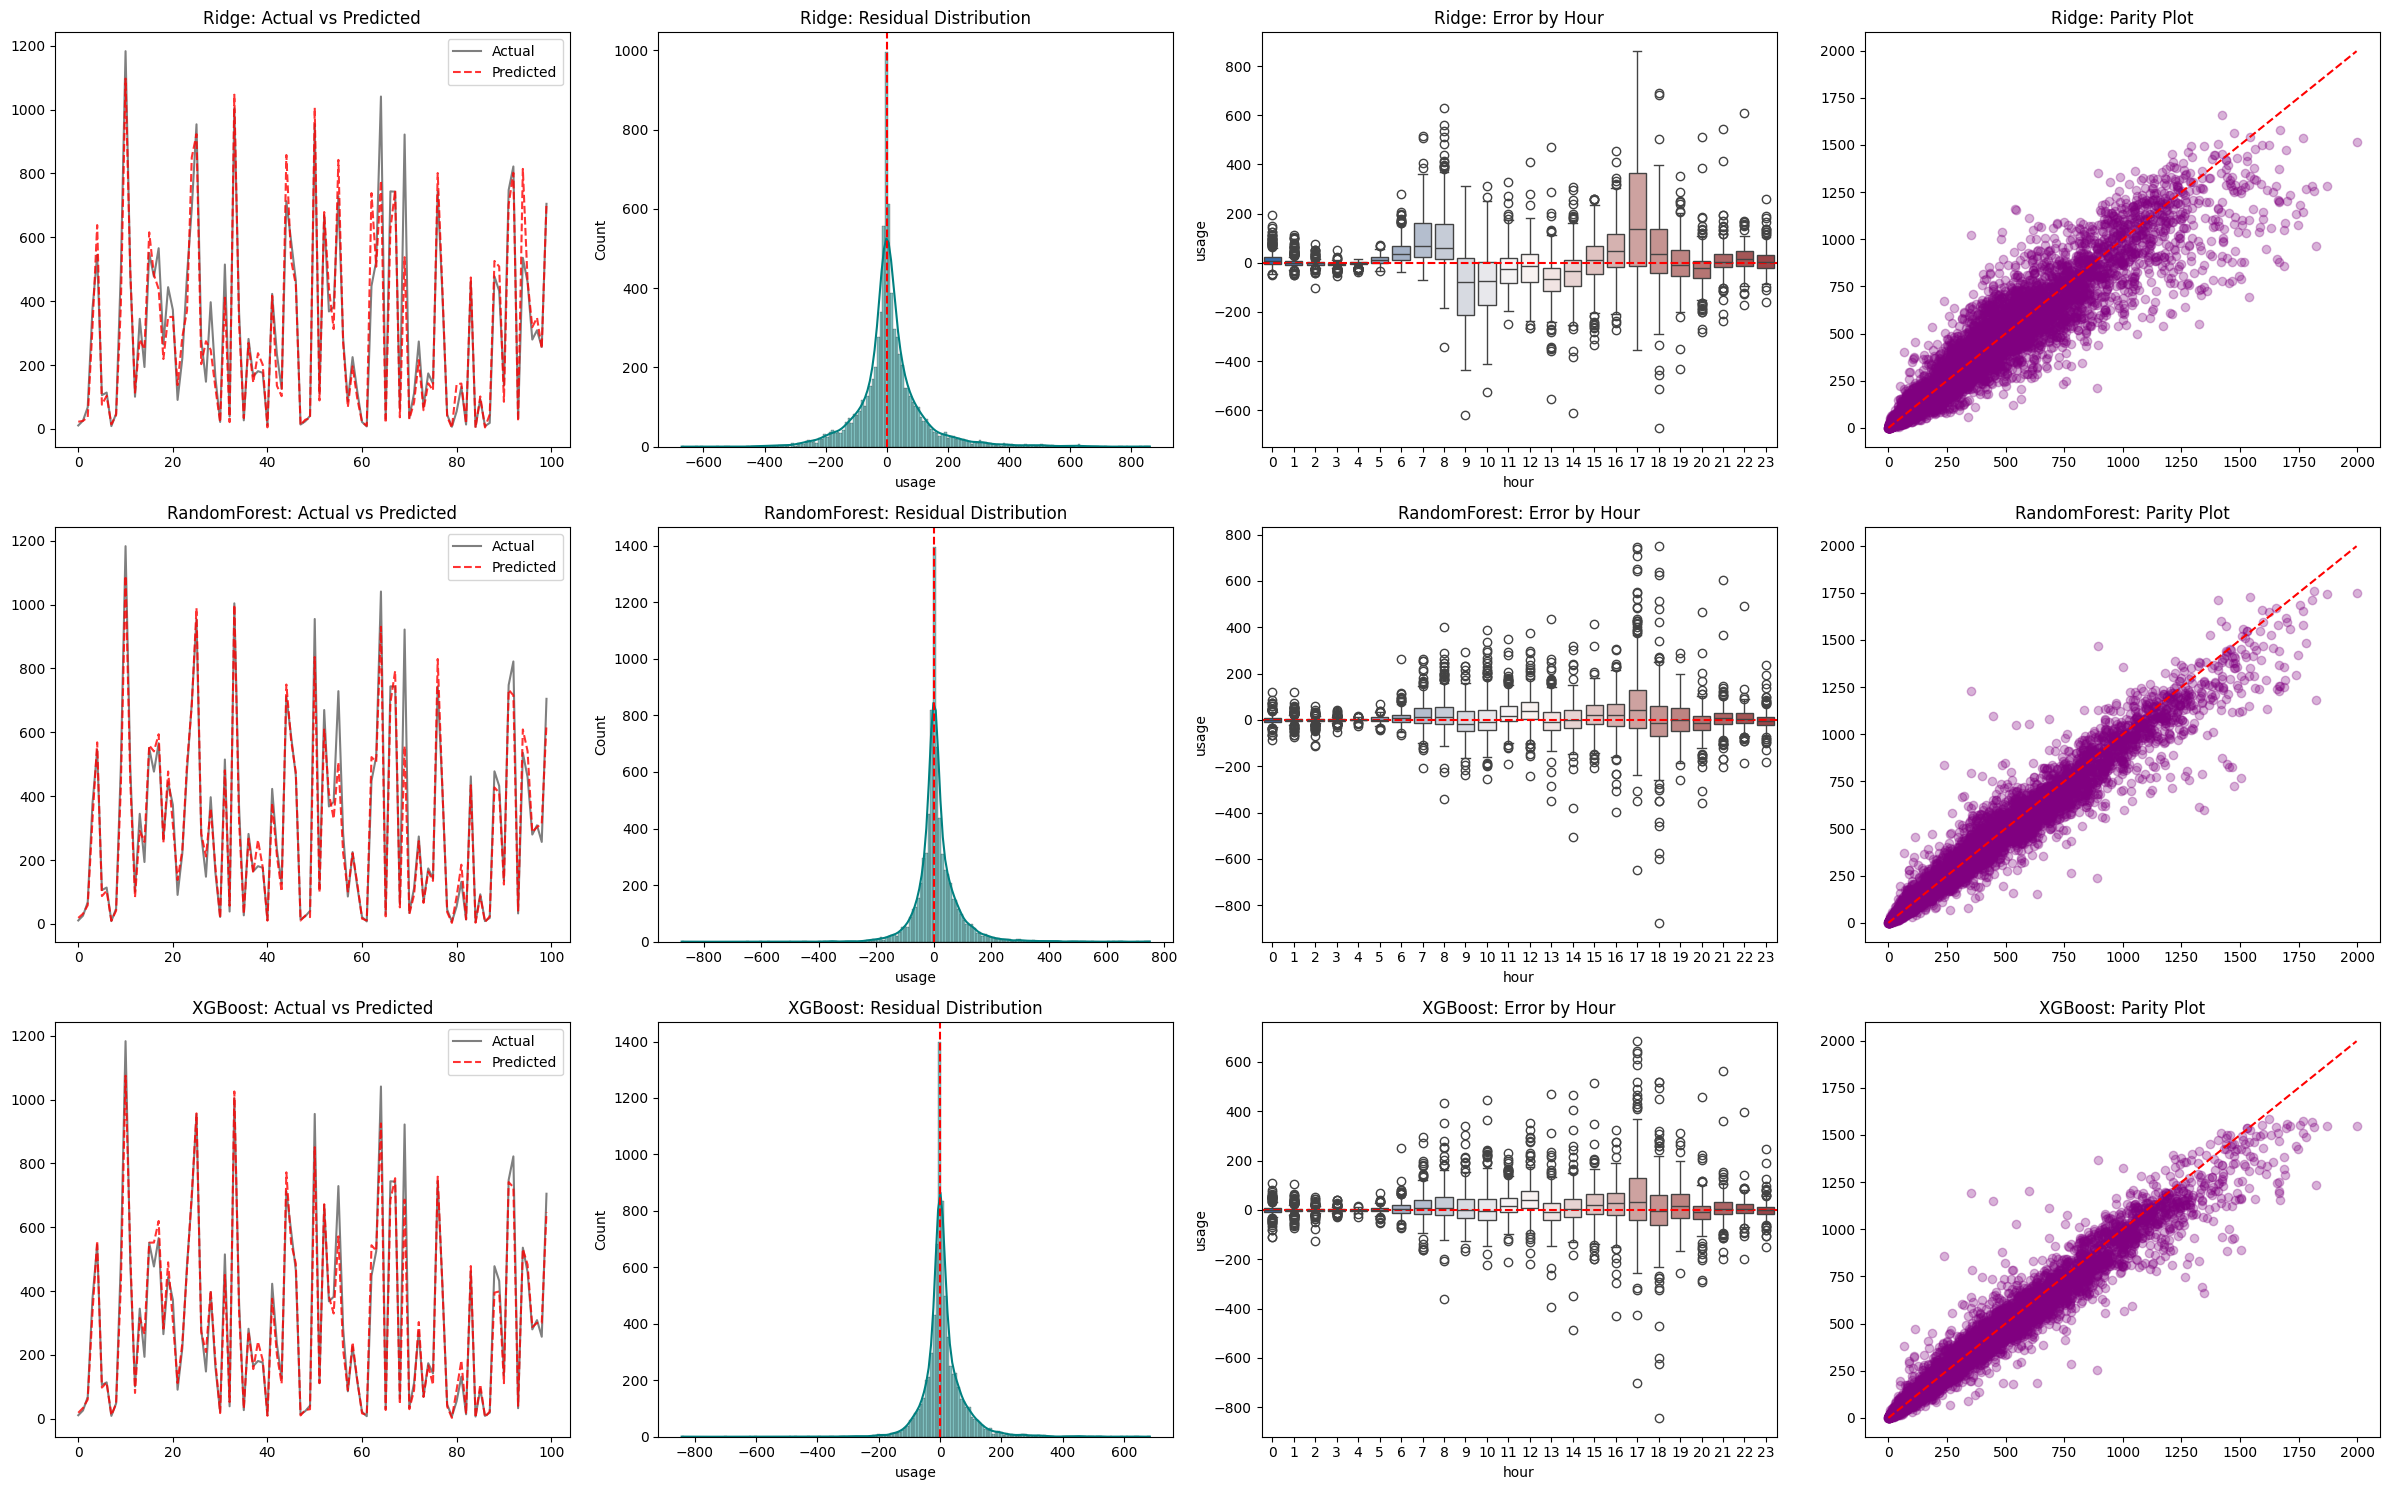


--- FINAL PERFORMANCE LEADERBOARD ---
          Model  WAPE (%)    MAE    RMSE      R2
2       XGBoost     11.39  42.05   73.22  0.9572
1  RandomForest     12.18  44.99   77.84  0.9516
0         Ridge     18.89  69.78  116.13  0.8923


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- STEP 1: FEATURE ENGINEERING PIPELINE ---
# Defining feature groups for targeted processing
categorical_features = ["dow", "icon", "weekend", "season"] 
numeric_features = ["date_since", "hour", "day", "month"]
lag_features = ["usage_lag_1h", "usage_lag_24h"]

# Preprocessor setup using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Handle categorical data via One-Hot Encoding
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        # Fixed: Added feature_names_out to prevent AttributeError in older scikit-learn versions
        ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one'), lag_features),
        # Pass through remaining numeric features
        ('num', 'passthrough', numeric_features)
    ]
)

# Shared feature processing pipeline for all models
feature_processing_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # Generate polynomial interactions (degree 2)
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    # Scale features for consistent model performance (StandardScaler recommended for Ridge/XGB)
    ('scaler', StandardScaler())
])

# --- STEP 2: UNIFIED DEEP EVALUATION FUNCTION ---
def deep_evaluate_models(models_dict, X_train, y_train, X_test, y_test, feature_pipeline):
    """
    Automates training, metric calculation (WAPE, RMSE, MAE, R2), 
    and diagnostic visualization for multiple regression models.
    """
    results = []
    num_models = len(models_dict)
    
    # Setup grid: 4 diagnostic plots per model (Horizontal)
    fig, axes = plt.subplots(num_models, 4, figsize=(24, 5 * num_models))
    if num_models == 1: axes = np.expand_dims(axes, axis=0)

    for idx, (name, model) in enumerate(models_dict.items()):
        print(f"Processing model: {name}...")
        
        # Wrap each regressor with Target Transformation to handle Log(y) internally
        full_pipeline = Pipeline([
            ('features', feature_pipeline),
            ('model', TransformedTargetRegressor(
                regressor=model, 
                func=np.log1p, 
                inverse_func=np.expm1
            ))
        ])
        
        # Fit model on raw training data
        full_pipeline.fit(X_train, y_train)
        # Predictions are automatically back-transformed to original scale
        y_pred = full_pipeline.predict(X_test)
        residuals = y_test - y_pred

        # 1. Performance Metrics Calculation
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        # WAPE (Weighted Absolute Percentage Error) is critical for demand forecasting
        wape = (np.sum(np.abs(residuals)) / np.sum(y_test)) * 100
        # R2 calculation using original scale
        r2 = r2_score(y_test, y_pred) 
        
        results.append({
            "Model": name, 
            "WAPE (%)": round(wape, 2), 
            "MAE": round(mae, 2), 
            "RMSE": round(rmse, 2), 
            "R2": round(r2, 4)
        })

        # 2. Diagnostic Plotting
        # Plot A: Actual vs Predicted (Time-series Sample)
        axes[idx, 0].plot(y_test.values[:100], label='Actual', color='black', alpha=0.5)
        axes[idx, 0].plot(y_pred[:100], label='Predicted', color='red', linestyle='--', alpha=0.8)
        axes[idx, 0].set_title(f'{name}: Actual vs Predicted')
        axes[idx, 0].legend()

        # Plot B: Residual Distribution
        sns.histplot(residuals, kde=True, ax=axes[idx, 1], color='teal')
        axes[idx, 1].axvline(0, color='red', linestyle='--')
        axes[idx, 1].set_title(f'{name}: Residual Distribution')

        # Plot C: Error by Hour (Detecting specific time-based bias)
        sns.boxplot(x=X_test['hour'], y=residuals, ax=axes[idx, 2], hue=X_test['hour'], palette="vlag", legend=False)
        axes[idx, 2].axhline(0, color='red', linestyle='--')
        axes[idx, 2].set_title(f'{name}: Error by Hour')

        # Plot D: Parity Plot (Overall Prediction Accuracy)
        axes[idx, 3].scatter(y_test, y_pred, alpha=0.3, color='purple')
        axes[idx, 3].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        axes[idx, 3].set_title(f'{name}: Parity Plot')

    plt.tight_layout()
    plt.show()
    return pd.DataFrame(results).sort_values(by="WAPE (%)")

# --- STEP 3: MODEL CONFIGURATION AND EXECUTION ---
# Using n_jobs=-1 for high-performance parallel processing in tree models
models_to_compare = {
    "Ridge": Ridge(alpha=10.0), # Increased alpha to ensure stability
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=42)
}

# Run the consolidated training and evaluation
df_final = deep_evaluate_models(
    models_to_compare, 
    X_train, y_train, 
    X_test, y_test, 
    feature_processing_pipeline
)

# Output final leaderboard
print("\n--- FINAL PERFORMANCE LEADERBOARD ---")
print(df_final)